# Open Data

NYC Open Data is a collection of free, public datasets that allow anyone to learn about how NYC works.
You can visit nyc.gov/opendata to explore approximately 3,000 datasets on nearly every part of City life! This includes information on schools, restaurants, streets, film permits, parks & trees, budget, and public safety stats – even datasets with the names of newborn babies and newly licensed dogs!!

Using Open Data:
* Every dataset on NYC Open Data is required to have a data dictionary - this is the first place you should look when you find a dataset you are interested in so that you understand what you’re looking at.
* There are several ways to work with datasets on NYC Open Data:
    1. You can do basic filtering and grouping functions within the portal itself (this can be helpful before downloading a large dataset);
    2. You can download the datasets in a variety of formats for analysis;
    3. You can also access every dataset via an API. Each API has its own documentation and code snippets. Here’s an [example for 311](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9)
* Introductory classes, where you can learn more about the background of NYC Open Data and how to use it, are held at least once a month. See the schedule and sign up at [nyc.gov/discoveropendata](https://nyc.gov/discoveropendata)

Contacting Open Data:
* If you are having issues using a dataset or if you would like to request a dataset that isn’t yet on NYC Open Data, you can reach out to the Open Data help desk at [nyc.gov/askopendata](https://nyc.gov/askopendata). 

Open Data Week:
* Each March, we co-organize Open Data Week with the civic technology group BetaNYC, and the Data through Design art collective. 
* Open Data Week celebrates the many ways New Yorkers engage with this free public data with dozens of virtual and in-person events, including demos of new tools, case studies, skill-building presentations, and glimpses into the data-driven functions of some City agencies!
* Open Data Week 2025 will be held from March 22 to March 30. You can visit [open-data.nyc](https://open-data.nyc) to submit an event proposal and to sign up for updates.

## Helpful links

[Link](https://docs.google.com/presentation/d/1sdVNKXQjs3iyQPTYbs97TkdySpklFNeI/edit?usp=sharing&ouid=115580000486856316060&rtpof=true&sd=true) to introductory slides.

[Link](https://bit.ly/oda-class-onepager) to Open Data resources

[Link](http://nyc.gov/discoveropendata) to sign up for an introductory class

[Link](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9) to 311 data dictionary

# Open Data Rat Complaints

We know that 311 service requests can be found on Open Data [here](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data). This dataset is large, so we should use the API query to access it!

## Socrata API

In [1]:
# Ensure you have all of your packages installed
# !pip install sodapy

In [2]:
import pandas as pd
import os
from sodapy import Socrata
import time
import math

import matplotlib.pyplot as plt

# If you save your application token in a .env file, you can load it using this command. 
from dotenv import load_dotenv
load_dotenv()

True

Using the [API documentation](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9), we can see that the dataset id is "erm2-nwe9" (which is also in the open data hyperlink).

You should generally use an [application token](https://dev.socrata.com/docs/app-tokens.html) when accessing the Socrata Open Data API. Otherwise you'll be subjected to strict throttling limits. I recommend saving your token as an environment variable, but you can also use a string (just be careful not to save your token in a public place, like in a public github repo).

In [3]:
# I would recommend saving your socrata token as an environment variable!
app_token = os.getenv('SOCRATA_API')
# You could also save it as a string. The default is None. 
# SOCRATA_API = None

# Save the 311 dataset id
dataset_id = 'erm2-nwe9'

The Socrata API lets you filter your data, which helps when you're using large datasets. 
Some of the standard filters can be found [here](https://dev.socrata.com/docs/queries/).
It's often helpful to filter on dates, which can be a bit trickier ([link](https://dev.socrata.com/docs/transforms/)). 

In [4]:
where_str = '''
1=1 AND (
((complaint_type = 'School Maintenance') AND (descriptor = 'Rodents/Mice'))
OR ((complaint_type = 'Food Establishment') AND (descriptor = 'Rodents/Insects/Garbage'))
OR ((complaint_type = 'Rodent') AND (descriptor = 'Rat Sighting'))
OR ((complaint_type = 'Rodent') AND (descriptor = 'Signs of Rodents'))
OR ((complaint_type = 'Maintenance or Facility') AND (descriptor = 'Rodent Sighting'))
OR ((complaint_type = 'Dead Animal') AND (descriptor = 'Rat or Mouse'))
OR ((complaint_type = 'UNSANITARY CONDITION') AND (descriptor = 'PESTS'))
) AND (date_trunc_ymd(created_date) >= '2019-01-01')
'''

In [5]:
%%time

# Note that you likely need to change the data limit
client = Socrata("data.cityofnewyork.us", app_token)
# timeout; default is 10sec
client.timeout = 120

results = client.get(dataset_id, where=where_str, limit=1000000)
opendata_df = pd.DataFrame.from_records(results)
print('Check if shape looks reasonable (does it match the provided limit?)')
opendata_df.shape

Check if shape looks reasonable (does it match the provided limit?)
CPU times: user 10.9 s, sys: 1.58 s, total: 12.4 s
Wall time: 34.5 s


(461861, 38)

I also wrote a small program (saved in socrata.py) that does this for you.

In [6]:
from socrata import socrata_api_query

rat_df = socrata_api_query(
    dataset_id=dataset_id,
    where=where_str,
    limit=1000000,
    timeout=120,
    token=os.getenv('SOCRATA_API')
)
rat_df.shape

Running query...
Duration: 2 min 33.16 sec


(461861, 38)

In [7]:
rat_df['created_date_dt'] = pd.to_datetime(rat_df['created_date'])
rat_df['year'] = rat_df['created_date_dt'].dt.isocalendar().year
rat_df['month'] = rat_df['created_date_dt'].dt.month

## Merge in geographic features

In [8]:
# !pip install geopandas
# !pip install shapley

In [9]:
import geopandas as gpd
from shapely.geometry import shape

In [10]:
keep_row = (
    (rat_df['created_date_dt'].dt.year == 2024)
    & (rat_df['created_date_dt'].dt.month == 9)
)
recent_rat_df = rat_df.loc[keep_row].copy()

In [11]:
rat_gdf = gpd.GeoDataFrame(
    recent_rat_df, crs='epsg:4326', 
    geometry=gpd.points_from_xy(recent_rat_df['longitude'], recent_rat_df['latitude'])
)

Get NYC borough geometries from Open Data ([link](https://data.cityofnewyork.us/dataset/nybb/7t3b-ywvw/about_data)).

In [12]:
nybb_df = socrata_api_query(dataset_id='7t3b-ywvw')
nybb_df['geometry'] = [shape(geo) for geo in nybb_df['the_geom']]

nybb_gdf = gpd.GeoDataFrame(
    data=nybb_df,
    geometry='geometry',
    crs='EPSG:4326'
)

No token passed
Running query...
Duration: 0 min 0.8695 sec


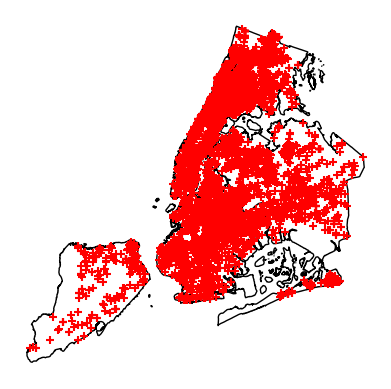

In [13]:
fig, ax = plt.subplots()

nybb_gdf.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black", facecolor='none')
rat_gdf.plot(ax=ax, marker='+', color='red')

ax.axis('off')

plt.show()

Generate the total counts of 311 rat complaints for community districts? 
* The relevant column in the 311 service request database is `community_board`
* The geometries for community boards are available [here](https://data.cityofnewyork.us/City-Government/Community-Districts/yfnk-k7r4); dataset id is 'jp9i-3b7y'.

In [14]:
cb_df = socrata_api_query(dataset_id='jp9i-3b7y')
cb_df['geometry'] = [shape(geo) for geo in cb_df['the_geom']]

cb_gdf = gpd.GeoDataFrame(
    data=cb_df,
    geometry='geometry',
    crs='EPSG:4326'
)

No token passed
Running query...
Duration: 0 min 0.7609 sec


In [15]:
# Note that community board is formatted differently in the 311 data
# than in the shapefile. Here, I format the community board data in the 
# 311 data
boro_dict = {
    'MANHATTAN': '1',
    'BRONX': '2', 
    'BROOKLYN': '3',
    'QUEENS': '4',
    'STATEN ISLAND': '5'
}

# Note: this code might not work if you have missing values
rat_gdf['boro_cd'] = (
    rat_gdf['borough'].map(boro_dict) 
    + rat_gdf['community_board'].str.extract(r'(^\d+)').squeeze()
)

In [16]:
# generate counts by community board
rat_cb_df = rat_gdf.groupby('boro_cd')['unique_key'].count().reset_index()

# merge in the geometries
rat_cb_df = pd.merge(
    left=rat_cb_df,
    right=cb_gdf,
    on='boro_cd',
    how='left',
    validate='m:1',
)

# create a geo data frame
rat_cb_gdf = gpd.GeoDataFrame(
    data=rat_cb_df,
    geometry='geometry',
    crs='EPSG:4326'
)

<Axes: >

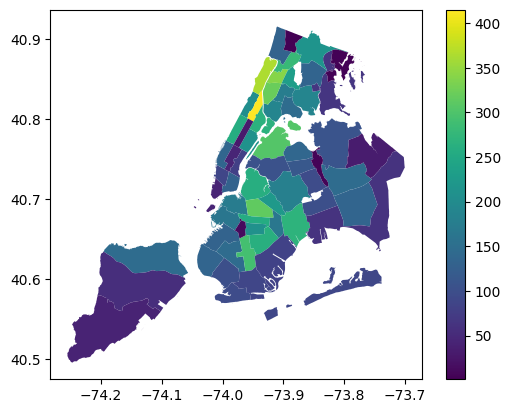

In [17]:
rat_cb_gdf.plot(column='unique_key', legend=True)

## Changes in Rat population

In [18]:
def count_sr_num(
    geo=None, 
    keep_after_year=2022, 
    groupvars=['year', 'month', 'agency', 'complaint_type', 'descriptor']
):
    '''Count service requests (311 calls) after 2022'''
    
    if geo is not None: 
        groupvars = [geo] + groupvars
    
    sr_num_count = (
        rat_df.loc[rat_df['year'] >= keep_after_year]
        .groupby(groupvars)['unique_key'].count()
    )

    sr_num_count.sort_index(
        axis=0,
        level=groupvars,
        inplace=True
    )

    sr_num_count = sr_num_count.reset_index()
    
    sr_num_count.rename(columns={'unique_key': 'count'}, inplace=True)
    
    return sr_num_count

In [19]:
sr_count_all = count_sr_num()
sr_count_all['geography'] = 'ALL NYC'

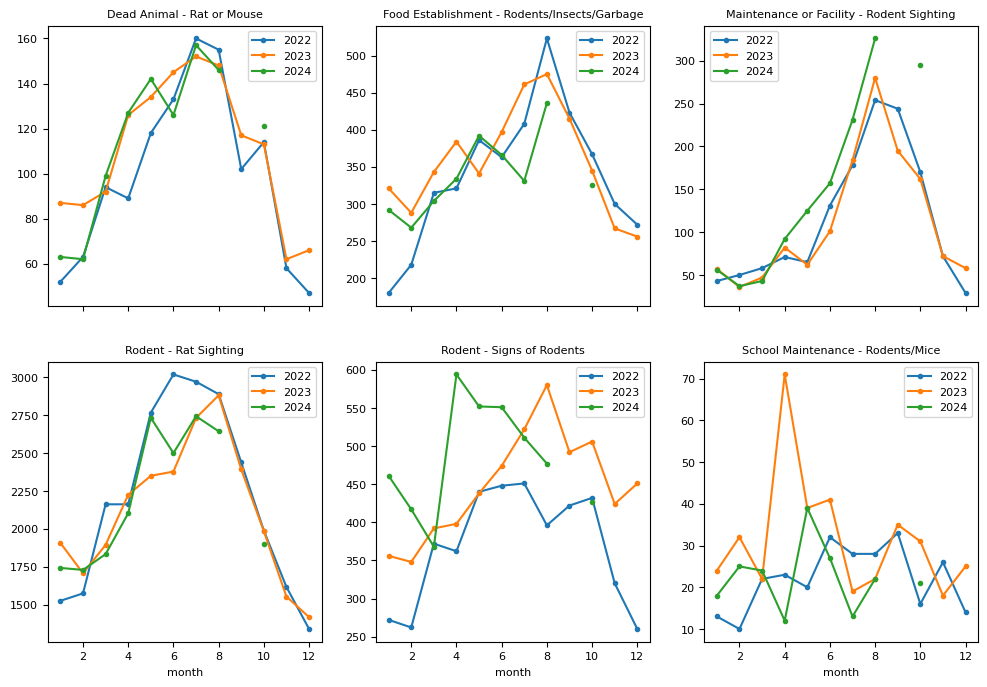

In [20]:
monthly_df = sr_count_all.drop(columns='geography')

# drop month with incomplete data
drop_row = ((monthly_df['year'] == 2024) & (monthly_df['month'] == 9))
drop_idx = monthly_df.loc[drop_row].index
monthly_df.drop(index=drop_idx, inplace=True)

# format title of plots
monthly_df['complaint'] = monthly_df['complaint_type'] + ' - ' + monthly_df['descriptor']
# weekly_df[['year', 'month', 'complaint',]]
monthly_df = monthly_df.pivot(index='month', columns=['complaint', 'year'], values='count')

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

for col, ax in zip(monthly_df.columns.levels[0], axes.flatten()):
    
    monthly_df[col].plot(ax=ax, marker='.')
    
    ax.set_title(col, size=8)
    
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    ax.legend(fontsize=8)
    
    ax.set_xlabel('month', fontsize=8)

In [21]:
sr_count_boro = count_sr_num(geo='borough', groupvars=['year', 'month'])

drop_row = sr_count_boro.loc[sr_count_boro['borough'] == 'Unspecified']
drop_idx = drop_row.index
sr_count_boro = sr_count_boro.drop(index=drop_idx)

sr_count_boro.rename(columns={'borough': 'geography'}, inplace=True)

(np.float64(0.44999999999999996),
 np.float64(12.55),
 np.float64(0.0),
 np.float64(1.0))

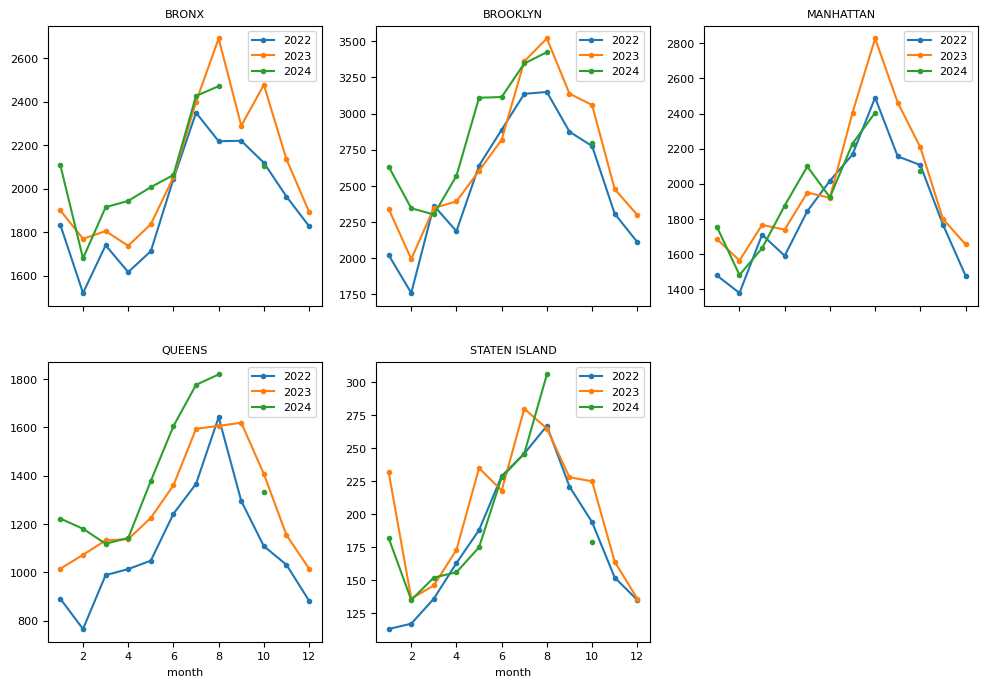

In [22]:
monthly_df = sr_count_boro.copy()

# drop month with incomplete data
drop_row = ((monthly_df['year'] == 2024) & (monthly_df['month'] == 9))
drop_idx = monthly_df.loc[drop_row].index
monthly_df.drop(index=drop_idx, inplace=True)

# pivot data to plot
monthly_df = monthly_df.pivot(index='month', columns=['geography', 'year'], values='count')

# generate plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

for col, ax in zip(monthly_df.columns.levels[0], axes.flatten()):
    
    monthly_df[col].plot(ax=ax, marker='.')
    
    ax.set_title(col, size=8)
    
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    
    ax.legend(fontsize=8)
    
    ax.set_xlabel('month', fontsize=8)
    
axes[1, 2].axis('off')